# Interpretable Machine Learning with SHAP Values

In [1]:
import pandas as pd
import shap
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

%matplotlib inline

CACHE = True


shap.initjs()

np.random.seed(1234)

#selected_features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']
X, y = shap.datasets.california()

# combined dataframe
df = pd.DataFrame(X, columns=X.columns)
df['price'] = y

#X = X[selected_features]

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [3]:
# # Generate a profile report

# # Or use the minimal option which might have fewer widget dependencies
# profile = ProfileReport(df, title="California Housing Dataset Profile", minimal=False)
# # Save the report to an HTML file
# profile.to_file("california_housing_report.html")

# A Motivating Example: Linear Regression

Linear regression models are simply enough to be considered "intrinsically interpretable". The prediction from a linear model is simply the sum of the products of model coefficients and the variable values. 

$$
y = \beta_0 + \beta_1 x_1 + \dots + \beta_k x_k
$$

It might be tempting to use the magnitudes of the coefficients to determine the most important variables, but this would provide a misleading understanding of the model if the units of measure of the variables are different. 

In the California housing dataset, median income is measured in tens of thousands of dollars and the coefficient is 0.54, which is a similar magnitude to the rest of the coefficients. However, if we measure median income in dollars, then coefficient would 5 orders of magnitude greater than the rest of the coefficients and would be deemed the "most important" by magnitude. 

In [4]:
# Train a linear regression model using the specified features
linear_model_features = ['MedInc', 'HouseAge', 'AveRooms', 'AveOccup', 'Population', 'AveBedrms']
X_train_selected = X_train[linear_model_features]
X_test_selected = X_test[linear_model_features]

# Initialize and train the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train_selected, y_train)

# Print the model coefficients
coefficients = pd.DataFrame({
    'Feature': linear_model_features,
    'Coefficient': linear_model.coef_
})
print("Linear Regression Coefficients:")
print(coefficients)
print(f"\nIntercept: {linear_model.intercept_:.4f}")

Linear Regression Coefficients:
      Feature  Coefficient
0      MedInc     0.540557
1    HouseAge     0.016600
2    AveRooms    -0.223501
3    AveOccup    -0.004539
4  Population     0.000022
5   AveBedrms     1.037077

Intercept: -0.4440


There is a way to view the importance of each variable for an *individual prediction*. Since the predicted value of a linear model is a linear sum of coefficients multipled by the value of the variable (the $\beta_i  x_i$ terms in the sum), we can decompose the predictions into these products and view their magnitudes since they are all in the same unit of measure as the target variable.

In [5]:
# Calculate predictions manually by multiplying features by coefficients and adding intercept
manual_predictions = np.dot(X_test_selected, linear_model.coef_) + linear_model.intercept_
np.allclose(manual_predictions, linear_model.predict(X_test_selected))

True

In [6]:
# create a matrix of the products
linear_components = pd.DataFrame(np.concatenate(
    [
        np.repeat(linear_model.intercept_, X_test_selected.shape[0]).reshape((-1, 1)), 
        np.multiply(X_test_selected.values, linear_model.coef_)
    ], 
axis = 1), 
    columns = ['Intercept'] + linear_model_features
)

np.allclose(linear_components.sum(axis=1), (manual_predictions))

True

We can use these products as feature importances to create some simple visualizations such as a waterfall plot that shows how to get from the intercept of the model to the predicted value. 

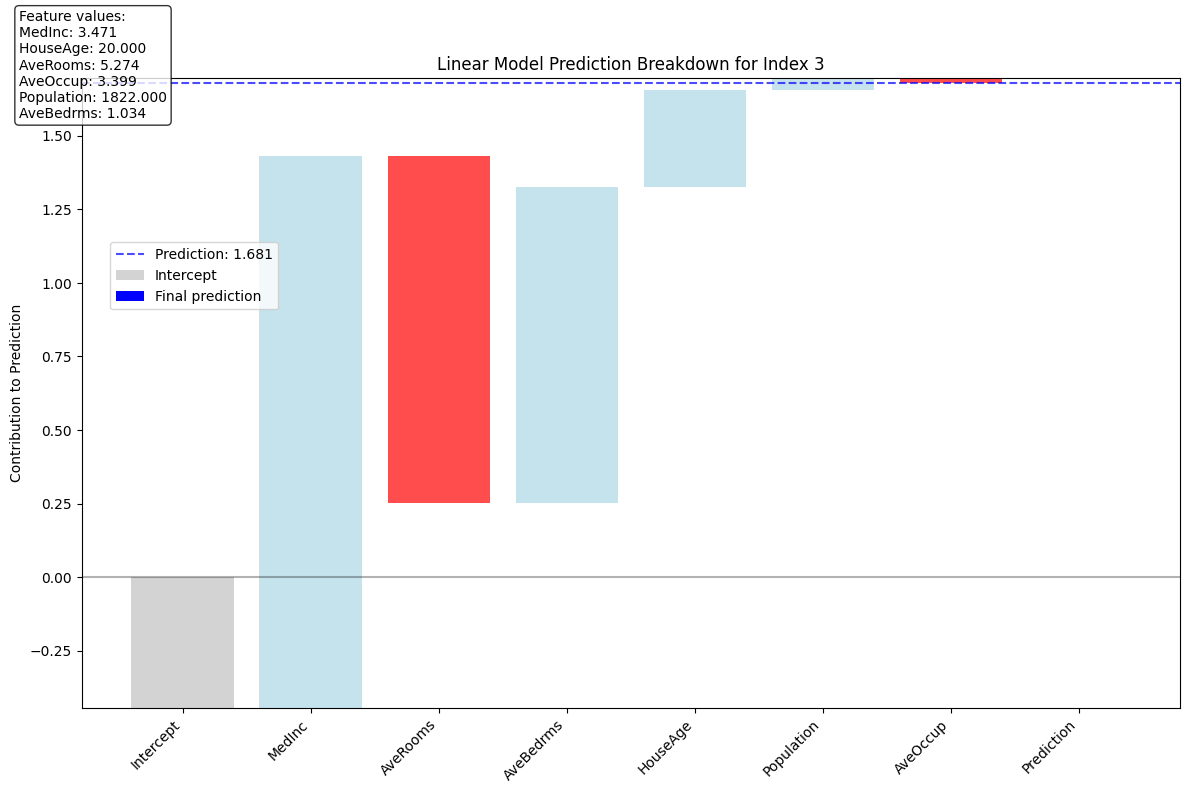

Prediction: 1.681

Feature contributions (sorted by magnitude):
MedInc: 1.876
AveRooms: -1.179
AveBedrms: 1.072
HouseAge: 0.332
Population: 0.039
AveOccup: -0.015


In [7]:
from utils import plot_linear_prediction_waterfall
plot_linear_prediction_waterfall(3, linear_components=linear_components,model=linear_model, X_test_selected=X_test_selected)

# Model Explainability for Tree-Based Models

We just saw how linear models are easily interpreted and how you can get a nice, clean, preduction 

In modern applications, the best results are often obtained using large datasets and complex, non-linear models whose output is difficult to interpret and whose inner mechanics are non-transparent and difficult to understand. In many settings, tree-based methods such as random forests and gradient boosting machines achieve the best performance, especially on tabular data that is often found in the business world. 

(insert shap citation) identify three desirable properties that a good feature importance measure should have

1. Consistency: If the model changes in such a way as to increase the marginal importance of a feature, the feature importance for that feature should not decrease
2. Prediction-level explainations: the feature importance measure can explain individual predictions, not just the global importance for the entire model
3. Local Accuracy (Additivity): the sum of the feature importance measures for an individual prediction sum to the predicted value, i.e. $f(x) = \sum_{i} \phi_i$ where the $\phi_i$ are the feature importance measures for the $i$ th feature. (Note that this requires prediction-level explainations)


There are numerous feature importance measures for use with both trees and other classes of models. The ones that are the most often used are:

1. Permutation Importance 
2. Gain

We will give an example of each and explain why none of these satisfy all three properties and then introduce SHAP as the only feature importance measure that satisfied all three. 



In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import json


if CACHE:

    # Load pre-computed best parameters from JSON file
    try:
        with open('rf_best_params.json', 'r') as f:
            best_params = json.load(f)
            print("Loaded best parameters from file:", best_params)
        
        # Create RandomForest model with best parameters
        best_rf = RandomForestRegressor(**best_params, random_state=42)
        
        # Train the model
        best_rf.fit(X_train, y_train)
        
        # Evaluate on test set
        test_score = best_rf.score(X_test, y_test)
        print(f"R² Score on Test Set: {test_score:.4f}")
        
        # Calculate predictions and MSE on test set
        y_pred = best_rf.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        print(f"MSE on Test Set: {mse:.4f}")
    except FileNotFoundError:
        print("Cache file not found, will train model from scratch")

else:  

    # Set up hyperparameter search for Random Forest Regressor
    # Define the parameter grid to search
    param_dist = {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    }

    # Create the random forest regressor
    rf = RandomForestRegressor(random_state=42)

    # Set up k-fold cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Create the RandomizedSearchCV
    rf_random = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=50,  # Number of parameter settings to try
        scoring='neg_mean_squared_error',
        cv=cv,
        verbose=1,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )

    # Fit the random search
    rf_random.fit(X_train, y_train)

    # Print the best parameters and score
    print("Best Parameters:", rf_random.best_params_)
    print("Best CV Score:", -rf_random.best_score_)  # Convert back to positive MSE

    # Save best parameters to JSON file

    best_params = rf_random.best_params_
    with open('rf_best_params.json', 'w') as f:
        json.dump(best_params, f, indent=4)

    print("Best parameters saved to rf_best_params.json")

    # Evaluate on test set
    best_rf = rf_random.best_estimator_
    test_score = best_rf.score(X_test, y_test)
    print(f"R² Score on Test Set: {test_score:.4f}")

    # Calculate MSE on test set
    y_pred = best_rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"MSE on Test Set: {mse:.4f}")

Loaded best parameters from file: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': False}
R² Score on Test Set: 0.8142
MSE on Test Set: 0.2488


## Permutation Importance

Permutation importance works by randomly shuffing a feature then watching how accuracy of the model degrades. By breaking the dependence between the feature and the target variable, the idea is that we can see how much the model truely relies on that feature.

Since permutation importances is measured with respect to model performance, computing it using the training set can provide misleading results on overfitted models, so it is best practice to calculate it using data not used to train the model. 


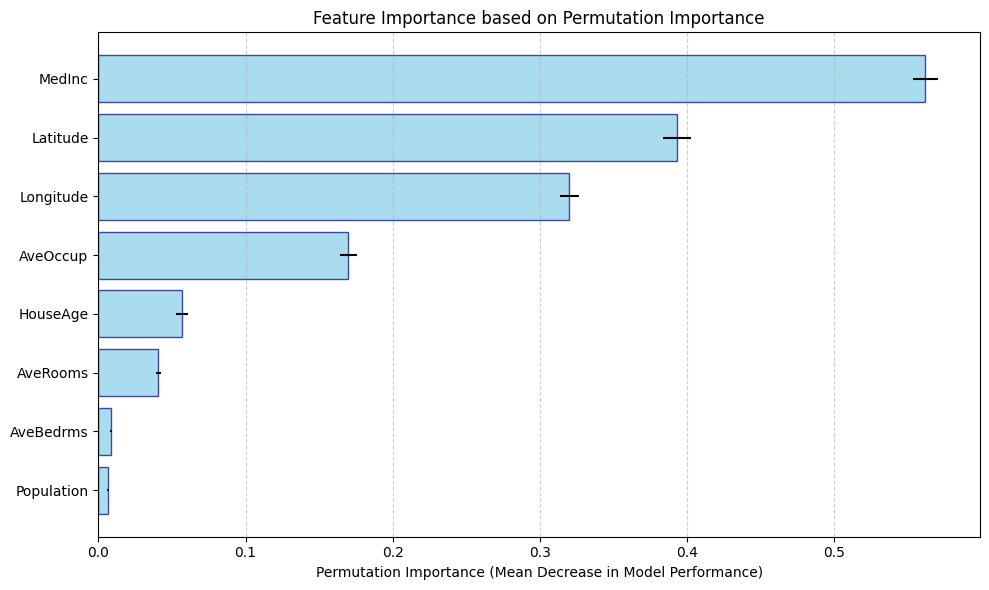

Population: 0.0063 ± 0.0008
AveBedrms: 0.0085 ± 0.0007
AveRooms: 0.0407 ± 0.0015
HouseAge: 0.0565 ± 0.0041
AveOccup: 0.1698 ± 0.0057
Longitude: 0.3199 ± 0.0063
Latitude: 0.3928 ± 0.0094
MedInc: 0.5618 ± 0.0085


In [9]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance for RandomForest model

# Calculate permutation importance
perm_importance = permutation_importance(best_rf, X_test, y_test, n_repeats=10, random_state=42)

# Sort the permutation importance by value
sorted_indices = perm_importance.importances_mean.argsort()
sorted_importances = perm_importance.importances_mean[sorted_indices]
sorted_features = X.columns[sorted_indices]
sorted_std = perm_importance.importances_std[sorted_indices]

# Create horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_features)), sorted_importances, xerr=sorted_std, 
         color='skyblue', edgecolor='navy', alpha=0.7)

# Add feature names as y-tick labels
plt.yticks(range(len(sorted_features)), sorted_features)

# Add labels and title
plt.xlabel('Permutation Importance (Mean Decrease in Model Performance)')
plt.title('Feature Importance based on Permutation Importance')

# Add grid for better readability
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print the actual values for reference
for feature, importance, std in zip(sorted_features, sorted_importances, sorted_std):
    print(f"{feature}: {importance:.4f} ± {std:.4f}")

### Advantages

* Easy to understand and implement; provides a quick, global overview of feature importance
* Can be used with any model
* Satisfies the *consistency* property

### Disadvantages

* Permuting the values of a single features can produce data points outside the distribution of the data when features are correlated. 
* Does not provide prediction-level feature importances and so cannot be locally accurate
* Permutation importance can split the importance between correlated features, making one (or both) features seem less important than they actually are
* Permutation importance uses the model *performance* instead of *output*, and this may not be what you want depending on the context

The plot below uses some dummy data to illustrate the effect on the data disbritution of permuting a feature when two features are correlated. The points in red are the result of permuting Feature 1, which generates unrealistic data points that are outside the joint distribution of Features 1 and 2. 

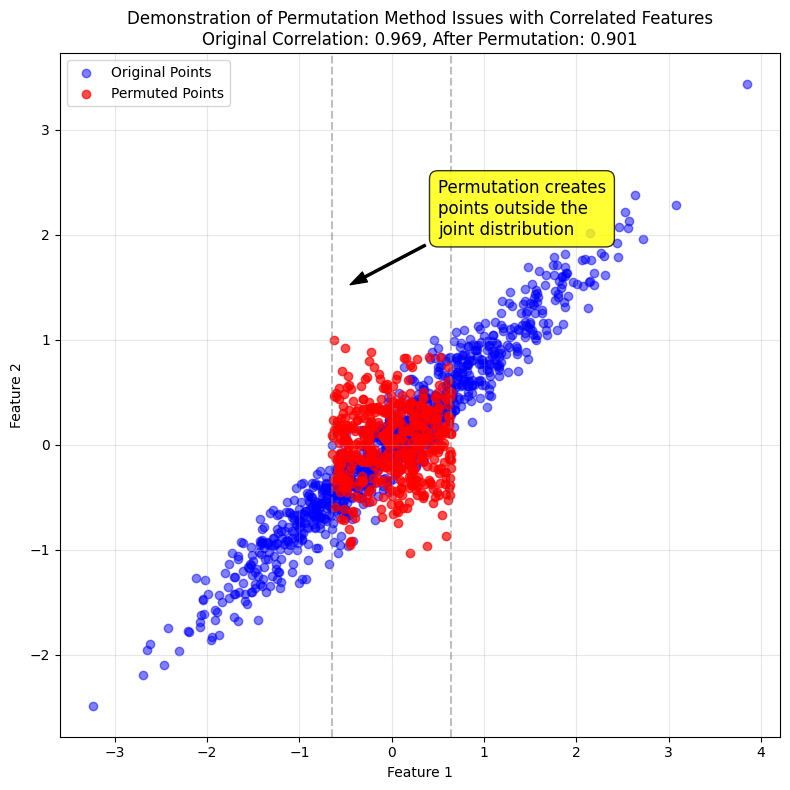

In [10]:
from utils import plot_permuted_correlated_features
plot_permuted_correlated_features()

## Gain 

Gain a feature importance measure that is unique to tree-based models that is calculated as the total reduction of loss or impurity contributed by all splits
for a given feature. 

### Advantages

* Is calculated "for free" with the training of the model


### Disadvantages

* Since it is based on the *training data*, it is suseptible to overfitting
* Does not satisfy any of the three properties of consistency, prediction-level explainations or local accuracy
* It favors continues features over categorical features since there are more opprotunities for splitting. This is also true for high-cardinality categorical features as well that have large numbers of possible splits to choose from
* Not model agnostic, only works with tree-based methods

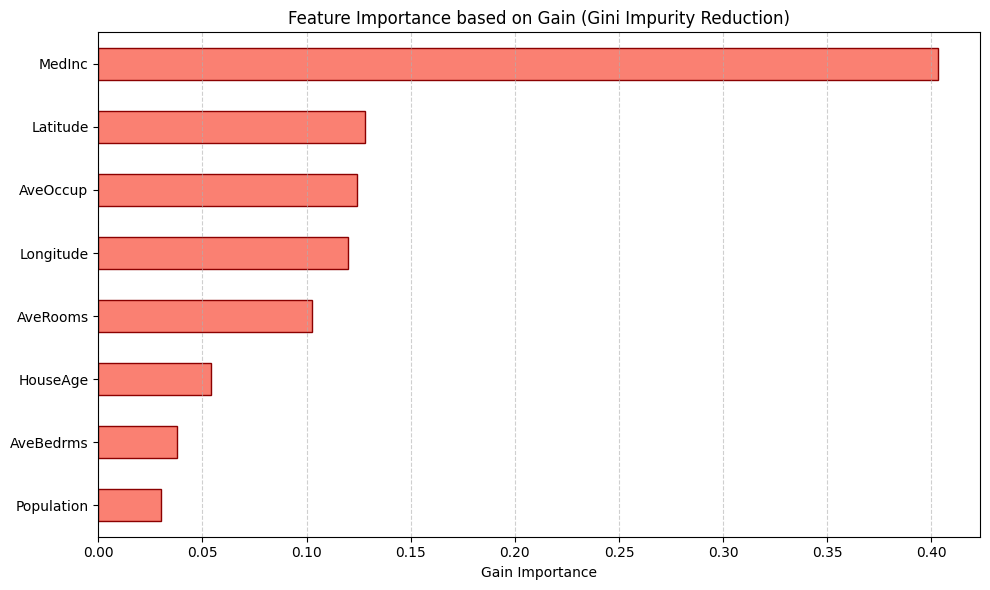

Population: 0.030192
AveBedrms: 0.037859
HouseAge: 0.054283
AveRooms: 0.102357
Longitude: 0.120074
AveOccup: 0.124234
Latitude: 0.127828
MedInc: 0.403173


In [11]:
# Calculate gain importance from the random forest model
gain_importance = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=True)

# Create horizontal bar plot for gain importance
plt.figure(figsize=(10, 6))
gain_importance.plot.barh(color='salmon', edgecolor='darkred')

# Add labels and title
plt.xlabel('Gain Importance')
plt.title('Feature Importance based on Gain (Gini Impurity Reduction)')

# Add grid for better readability
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

# Print the actual values
for feature, importance in gain_importance.items():
    print(f"{feature}: {importance:.6f}")

## Introduction to SHAP Values for Tree-Based Models

SHAP values stand for **SHapley Additive Predictions** were introduced in 2017 by Lundberg and Lee [1]. They are based on Shapely values from cooperative game theory, which is a theoretically sound way to fairly allocate the payouts to players in a coopoerative game. We won't take the game theory connections too far here, but you can think of the "game" as the machine learning model being explained, the "players" as the input features to the model, and the "payout" the model predictions. SHAP values calculate the contribution each feature made to the prediction. 

Lundberg and Lee showed that SHAP values are the only explainatory model that satisfies the three properties that we discussed earlier. 

1. Consistency
2. Local Accuracy / Additivity
3. Prediction-level explainations

Formally, additivity means that if $\phi_i$ is the SHAP value for the $i$ feature, the sum of the SHAP values equals *the difference between the model output and the expected output*. 

$$
f(x) = E[f(x)] + \sum_{i=1}^F \phi_i
$$

These properties unlock a variety of rich visualizations and diagnostic plots that we can use in place of the global feature importance measures that we just discussed. They can also be augmented by traditional Partial Dependence Plots and Individual Conditional Expectation plots, both of which we will review later in this presentation. 

### Some SHAP Theory

Formally, let 

$$
\phi_i =  \sum_{S\subseteq F/\{i\}} \frac{1}{|F|}  \frac{1}{\binom{|F|-1}{|S|}} \big[ f_{S\cup\{i\}} (x_{S\cup\{i\}}) - f_S(x_S) \big]
$$

where 

* $|F|$ is the number of features
* $|S|$ is the number of features in the subset $S \subset F$
* $f_{S\cup\{i\}}= E[f(x) | x_{S\cup\{i\}}]$ is the conditional expectation of the model given the features $x_{S\cup\{i\}}$
* $ f_S = E[f(x) | x_S]$ is the conditional expectation of the model given the features $x_S$


$\phi_0 = f_\empty(\empty)$ 

**In Words**

A one-line definition:

> A SHAP value is the average marginal change in the model output from adding a feature to a subset of features, averaged over all such subsets not containing that feature. 

More precisely: 

>To calculate the SHAP value for feature $i$, we consider all possible subsets $S$ of features that exclude feature $i$. For each subset, we compute the marginal contribution of adding feature $i$ to that subset, which is the difference between the expected model output when $S$ and feature $i$ are known versus when only $S$ is known. We then take the weighted average of these contributions across all possible subsets where the weights are related to the number of such subsets. 

In steps: 

1. Train a machine learning model $f$
2. For each feature $i$, consider all the subsets that exclude $i$
3. Compute the expected difference in the expected model outputs $E[f(x) | x_{S\cup\{i\}}] - E[f(x) | x_S]$ with and without the feature
4. Average over all subsets, with weights equal to the probability of selecting that particular subset

Let's unpack the last of these. The weights in the sum above are the probability of selecting a particular subset. The term has two parts: 

Given a feature $i$, the number of subsets of $S\subseteq F / \{i \}$ is
$$
\binom{|F|-1}{|S|}
$$, 

so the probability of selecting a subset, conditional on $i$ (and assuming selection happens uniformly) is

$$
 \frac{1}{\binom{|F|-1}{|S|}} 
$$

Since there are $|F|$ features in the model, the probability of selecting one of them uniformly is $\frac{1}{|F|}$. So the joint probability of selecting feature $i$ and subset $S\subseteq F / \{i \}$ is therefore

$$
\frac{1}{|F|}  \frac{1}{\binom{|F|-1}{|S|}} 
$$




In [12]:
from math import comb

F = len(X.columns)

combinations = {}
for i in range(1, F):
    combinations[i] = comb(F, i)

# Create a DataFrame to store the combinations
combinations_df = pd.DataFrame.from_dict(combinations, orient='index', columns=['Combinations'])
combinations_df.reset_index(inplace=True)

total_combinations = combinations_df['Combinations'].sum()


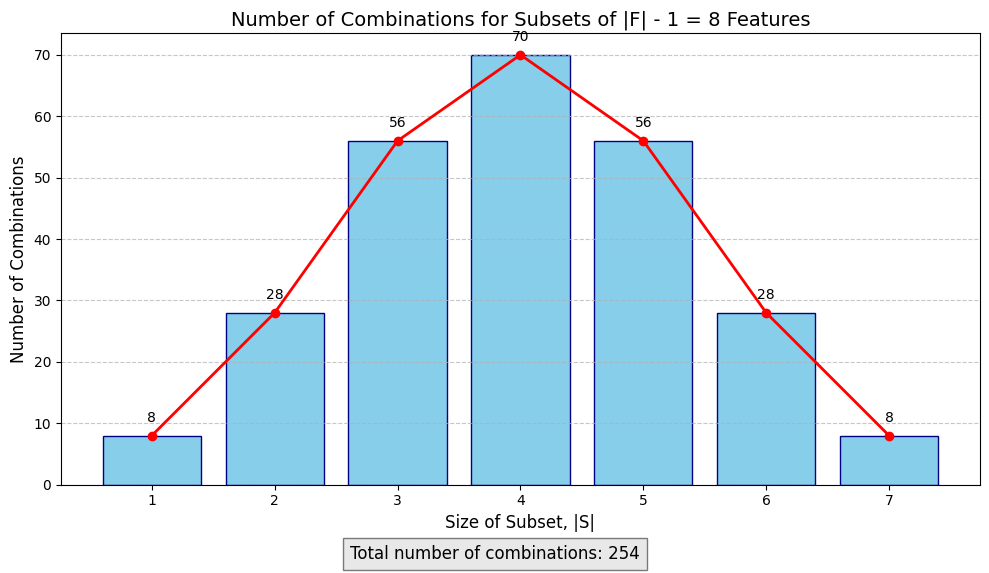

In [13]:
# Plot the number of combinations by subset size
plt.figure(figsize=(10, 6))
plt.bar(combinations_df['index'], combinations_df['Combinations'], color='skyblue', edgecolor='navy')

# Adding a curve to highlight the pattern
plt.plot(combinations_df['index'], combinations_df['Combinations'], 'ro-', linewidth=2)

# Add annotations for each point
for i, row in combinations_df.iterrows():
    plt.annotate(f"{int(row['Combinations'])}", 
                 (row['index'], row['Combinations']),
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')

# Add labels and title
plt.xlabel('Size of Subset, |S|', fontsize=12)
plt.ylabel('Number of Combinations', fontsize=12)
plt.title(f'Number of Combinations for Subsets of |F| - 1 = 8 Features', fontsize=14)

# Format x-axis
plt.xticks(combinations_df['index'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a note about the total
plt.figtext(0.5, 0.01, f"Total number of combinations: {total_combinations}", 
            ha="center", fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

As you can see, the number of possible combinations explodes exponentially with the number of features. The number of subsets in $F/\{i\}$ is 254, and since there are 9 features, the number of subsets to evaluate is:

In [14]:
len(X.columns) * total_combinations

2032

That is a lot of subsets! As you can see, the number of subsets explodes exponentially with the number of features.


### Computational Difficulties and TreeSHAP

There are two main issues with SHAP values:

1. Estimating the conditional expectations $E[f(x) | x_S]$ efficiently
2. The combinatorical complexity of the SHAP value equation

Fortunately, the breakthrough that Lundberg, Erion and Lee made in 2019 [2]  discovering a fast algorithm for computing SHAP values for tree-based models. The model is polynomial time, and allows large models with many features on large dataset to be explained quickly using SHAP. The algorithm is called TreeSHAP. 

The algorithm is able to compute  $E[f(x) | x_S]$ and does not require sampling or assuming features are independent (more on this later).

# Visualizations and Applications

In [15]:
from shap import TreeExplainer


X_test_sample = X_test.iloc[:200]


# Initialize the TreeExplainer
explainer = TreeExplainer(model = best_rf, feature_perturbation="tree_path_dependent")
shap_values = explainer(X_test_sample)

We can now verify the **local accuracy** property and confirm that the sum of the SHAP values equals the prediction.

In [16]:
np.allclose(best_rf.predict(X_test_sample), shap_values.values.sum(axis=1) + explainer.expected_value[0])

True

## Single Prediction Plots

### Waterfall Plot

SHAP provides plots that break down individual predictions into feature contributions (the SHAP values). The waterfall plot is a good way to see which features contributed to the prediction, their magnatude and direction. Blue arrows are for features that negatively contribute to the prediction relative to the baseline and the red arrows are for features that positively contribute relative to the baseline value. 

Remember that the SHAP values and arrows are *relative to the baseline value*.

This plot also offers a nice way to visualize the *local accuracy* property. We can see that the waterfall plot starts at the expected value $E[f(x)]$, which is the predicted value of the model with no features present, and then sum to the predicted value, which is when all features are present. 

In [17]:
sample_idx = 5

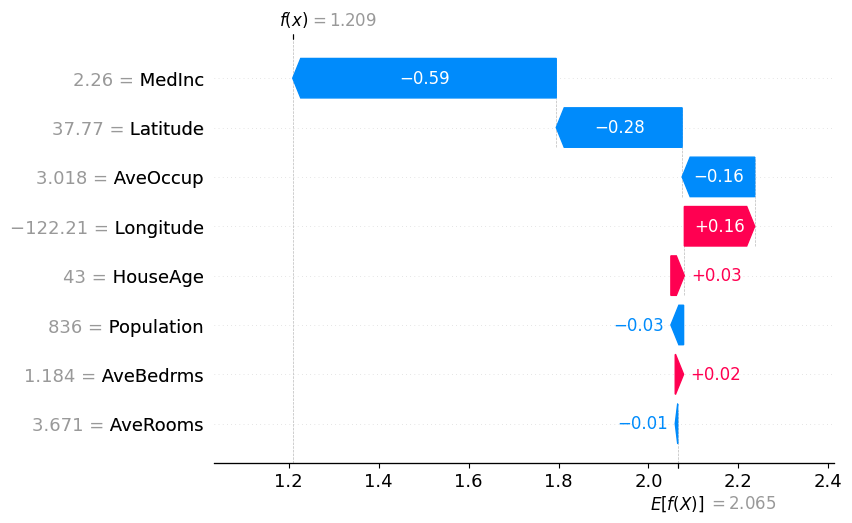

In [25]:
shap.plots.waterfall(shap_values[sample_idx])

In [ ]:
from utils import map_point


# sanity-check the interpretation of the SHAP plot by looking at where in California the sample is located
map_point(X_test_sample.iloc[sample_idx]['Latitude'], X_test_sample.iloc[sample_idx]['Longitude'], 
          y_test[sample_idx], y_pred[sample_idx], X_test_sample.iloc[sample_idx]['MedInc'], 
          X_test_sample.iloc[sample_idx]['HouseAge'], X_test_sample.iloc[sample_idx]['AveRooms'], 
          X_test_sample.iloc[sample_idx]['AveBedrms'], X_test_sample.iloc[sample_idx]['Population'], 
          X_test_sample.iloc[sample_idx]['AveOccup'])


### Force Plots

Force plots represent a more compact visualization than the waterfall plot, but shows the same information. 

In [27]:
# Create a force plot for the selected sample
shap.plots.force(shap_values[sample_idx], matplotlib=False, show=False)


## Global Plots

### SHAP Summary Plot

SHAP values can be aggregated to create to measure the global feature importance and get a ranking of the most important features, similar to the permutation and gain methods.

* Left:  feature importance ranked by the maximum absolute value of the feature's SHAP values
* Right: feature importance ranked to the mean absolute value of the feature's SHAP values

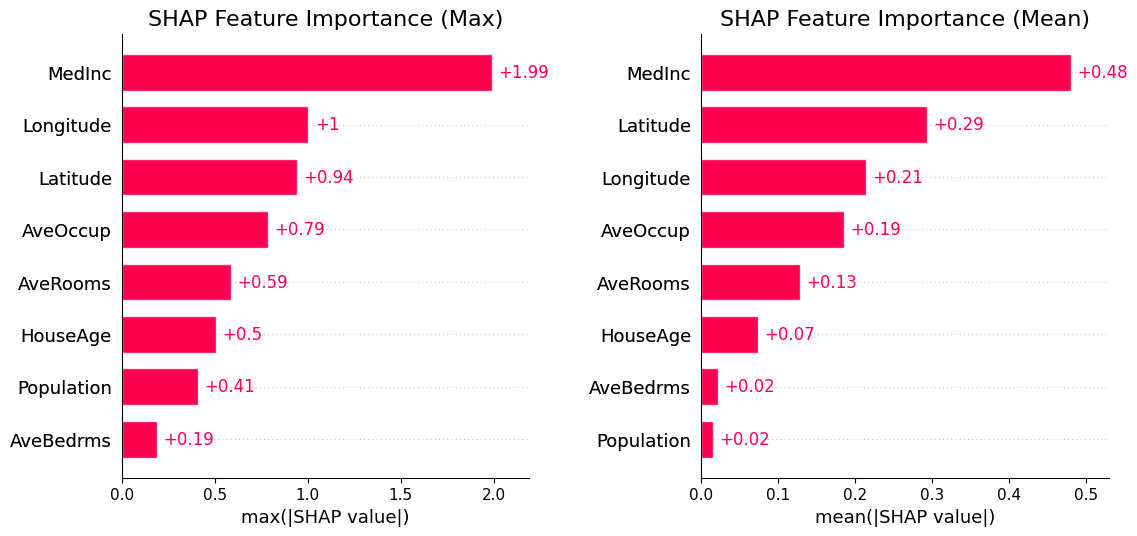

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

shap.plots.bar(shap_values.abs.max(0), max_display=10, show=False, ax=ax[0], )
ax[0].set_title("SHAP Feature Importance (Max)", fontsize=16)


shap.plots.bar(shap_values.abs.mean(0), max_display=10, show=False, ax=ax[1], )
ax[1].set_title("SHAP Feature Importance (Mean)", fontsize=16)

plt.tight_layout(pad=3)
#plt.suptitle("SHAP Feature Importance Comparison", fontsize=18, y=1.05)

### Beeswarm Plot

Beeswarm plots combine information information about the *importance*, *direction* and *distribution* of feature effects.

The features are sorted by the mean absolute value of the SHAP values for the feature and each dot displayed is an individual observation. Each dot's position on the x-axis is the SHAP value for that data instance's feature value. Negative values mean that feature had a negative contribution to the predicted output and a positive value means that feature had a positive contribution to the predicted output. 

The color of each dot is the value of the feature itself, scaled such that red means "high" and blue means "low". 

This combination of chart aspects allows us to get a sense of 

* The *spread* of SHAP values.
* The *feature's overall importance*: features with a wider spread and more dots that are far from zero have more global importance and features whose SHAP values cluster near zero have little influence on the model. 
* The *correlation between the feature value and its impact* via the color pattern: 

For example, looking at the `MedInc` (median income) feature, we can make several observations:

1. Based on the color pattern, lower median incomes tend to have a negative impact on the predicted home price. 
2. There is wide variation, with many points bunched below zero and a few number of high-income points having a large positive impact on the model. This is consistent with a "Pareto" wealth/income distribution, with a few areas of concentrated money with high home prices (this is characteristic of the California economy in general, with places like San Francisco, Beverley Hills, Palo Alto, Carmel etc. having very high incomes and home prices and many poor areas further inland from the coast)

The plot shows an interesting pattern for the geographic features. `Longtitude` is measured in *decimal degrees*, and we see that as we move further West (as measured by more negative values for this feature), the feature has a positive effect on the predicted output. This is consistent with the geography of California, where housing is more expensive the closer to the ocean you get. 



In [35]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


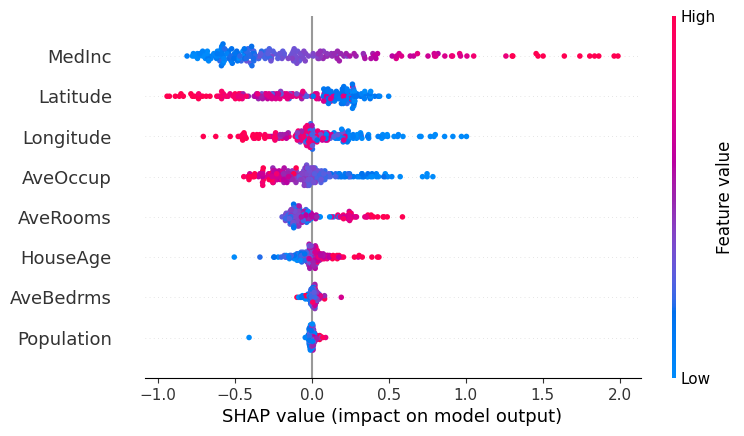

In [34]:
shap.plots.beeswarm(shap_values, show=True)

In [22]:
explainer.expected_value

array([2.06491939])

# References

1. Lundberg, S. M., & Lee, S.-I. (2017). *A Unified Approach to Interpreting Model Predictions*. In Proceedings of the 31st International Conference on Neural Information Processing Systems (NIPS 2017). [https://arxiv.org/abs/1705.07874](https://arxiv.org/abs/1705.07874)

2. Lundberg, S. M., Erion, G. G., & Lee, S.-I. (2019). *Consistent Individualized Feature Attribution for Tree Ensembles*. arXiv preprint arXiv:1802.03888. [https://arxiv.org/abs/1802.03888](https://arxiv.org/abs/1802.03888)

3. Frye, C., Rowat, C., & Feige, I. (2020). *Asymmetric Shapley Values: Incorporating Causal Knowledge into Model-Agnostic Explainability*. In Advances in Neural Information Processing Systems (NeurIPS 2020). https://arxiv.org/abs/1910.06358

4. SHAP Documentation: https://shap.readthedocs.io

5. Molnar, Christoph. *Interpretable Machine Learning: A Guide for Making Black Box Models Explainable*. 3rd ed., 2025. ISBN: 978-3-911578-03-5. Available at: https://christophm.github.io/interpretable-ml-book


